In [1]:
import pandas as pd
# import folium
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

# Load the data

In [2]:
# load the demographic profiles dataset from 
# https://data.cityofnewyork.us/City-Government/Demographic-Profiles-of-ACS-5-Year-Estimates-at-th/8cwr-7pqn/about_data
df_pop = pd.read_excel('./data/ACS5yrNTA/demo_2016acs5yr_nta.xlsx')
print(df_pop.shape)

df_econ = pd.read_excel('./data/ACS5yrNTA/econ_2016acs5yr_nta.xlsx')
print(df_econ.shape)

df_house = pd.read_excel('./data/ACS5yrNTA/hous_2016acs5yr_nta.xlsx')
print(df_house.shape)

df_soc = pd.read_excel('./data/ACS5yrNTA/soc_2016acs5yr_nta.xlsx')
print(df_soc.shape)

(195, 484)
(195, 659)
(195, 524)


/Users/pornpanitrasivisith/opt/anaconda3/envs/pantalone/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: #N/A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


(195, 2714)


In [3]:
# load the demographic profiles dataset from 
# https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh/about_data
df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')
print(df_bus.shape)

(281413, 27)


/var/folders/0f/0432hb3j0_97yqpm39c2hwlw0000gn/T/ipykernel_9108/940827208.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')


In [4]:
# check if there is any trader joe
df_bus[df_bus['Business Name'].str.lower().str.contains('trader') & df_bus['Business Name'].str.lower().str.contains('joe')]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [5]:
# filter business operating in NYC only
print(df_bus['Address Borough'].value_counts())

# filter the dataset to only keep 5 boroughs, remove rows with misspelling
NYC_BOROUGHS = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
df_bus = df_bus[df_bus['Address Borough'].isin(NYC_BOROUGHS)]
print(df_bus.shape)

Address Borough
Brooklyn         50346
Queens           45800
Manhattan        40435
Bronx            24695
Outside NYC      14775
Staten Island     9265
MANHATTAN           46
QUEENS              17
BROOKLYN            15
BRONX                9
Name: count, dtype: int64
(170541, 27)


In [6]:
# We want to focus on recommending the specific NTA (Neighborhood Tabulation Area) where the business is located.
# remove row with missing NTA
df_bus = df_bus.dropna(subset=['NTA'])
print(df_bus.shape)

df_bus[['Address Borough', 'NTA']].value_counts()

(137476, 27)


Address Borough  NTA 
Manhattan        MN17    4222
                 MN13    2288
                 MN24    1936
Queens           QN70    1905
                 QN61    1904
                         ... 
Brooklyn         MN24       1
Manhattan        BK78       1
                 BK91       1
Brooklyn         MN19       1
Queens           MN36       1
Name: count, Length: 209, dtype: int64

In [7]:
# check how many industries
df_bus['Industry'].value_counts()

Industry
Tobacco Retail Dealer             37491
Home Improvement Contractor       21261
Secondhand Dealer - General       12621
Electronics Store                 11933
Stoop Line Stand                   7376
Laundry                            6832
Electronic & Appliance Service     5325
Laundries                          4353
Laundry Jobber                     4339
Sidewalk Cafe                      3728
Garage                             3106
Electronic Cigarette Dealer        2923
Secondhand Dealer - Auto           2322
Parking Lot                        1720
Dealer In Products                 1600
Tow Truck Company                  1232
Employment Agency                  1102
Special Sale                       1005
Amusement Device Temporary          979
Amusement Device Portable           942
Pawnbroker                          766
Cabaret                             602
Debt Collection Agency              496
Pedicab Business                    422
Amusement Device Permanent     

# Feature Engineering

In [8]:
# Assume that the trader joe's lies in between  Stoop Line Stand  and General Vendor industries
# [Note that general vendor was filtered as they are outside the NYC]
# let's use the sum of businesses of two industries as an indicator of supermarket success

df_sup_success = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
df_sup_success = df_sup_success[['Address Borough', 'NTA', 'Business Name', 'Industry']]
df_sup_success = df_sup_success.groupby(['NTA'])['Business Name'].count().reset_index()
df_sup_success = df_sup_success.rename(columns={'Business Name':'Shop_Count', 'NTA':'GeoID'})
df_sup_success.head(5)

,GeoID,Shop_Count
0,BK09,12
1,BK17,58
2,BK19,173
3,BK21,24
4,BK23,5


In [9]:
# get the parking lot count per NTA
df_parking = df_bus[df_bus['Industry'].isin(['Garage', 'Parking Lot', 'Garage and Parking Lot'])] 
df_parking = df_parking[['Address Borough', 'NTA', 'Business Name', 'Industry']]
df_parking = df_parking.groupby(['NTA'])['Business Name'].count().reset_index()
df_parking = df_parking.rename(columns={'Business Name':'Parking_Count', 'NTA':'GeoID'})
df_parking.head(5)

,GeoID,Parking_Count
0,BK09,38
1,BK17,9
2,BK19,4
3,BK21,12
4,BK23,10


In [10]:
# create NTA-level data
df_nta = pd.merge(df_pop, df_sup_success, on=['GeoID'])
df_nta = pd.merge(df_nta, df_parking, on=['GeoID'])
df_nta = pd.merge(df_nta, df_econ, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta = pd.merge(df_nta, df_house, on='GeoID')
df_nta = pd.merge(df_nta, df_soc, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta.shape

(141, 4368)

In [11]:
df_nta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Columns: 4368 entries, GeoID to UnclsNRZ
dtypes: float64(3511), int64(856), object(1)
memory usage: 4.7+ MB


In [12]:
# create new features
df_nta['Pop_Total_25_44'] = df_nta.apply(lambda x: x['Pop25t29E'] + x['Pop30t34E'] + x['Pop35t39E'] + x['Pop40t44E'], axis=1)
df_nta['Pop_Pct_25_44'] = df_nta.apply(lambda x: x['Pop_Total_25_44'] / x['Pop_1E'] , axis=1)
df_nta['Pop_Male'] = df_nta.apply(lambda x: x['MaleE'] / x['Pop_1E'] , axis=1)
df_nta['Pop_Female'] = df_nta.apply(lambda x: x['FemE'] / x['Pop_1E'] , axis=1)
df_nta['Median_Age'] = df_nta['MdAgeE']
df_nta['Pop_Pct_Hisp_Latin'] = df_nta.apply(lambda x: x['Hsp1E'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Non_Hisp_Latin'] = df_nta.apply(lambda x: x['NHspE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_White'] = df_nta.apply(lambda x: x['WtNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Black'] = df_nta.apply(lambda x: x['BlNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_American'] = df_nta.apply(lambda x: x['AIANNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Asia'] = df_nta.apply(lambda x: x['AsnNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Native'] = df_nta.apply(lambda x: x['NHPINHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Employ'] = df_nta.apply(lambda x: x['CvEm16pl1E'] / x['Pop16plE'], axis=1) 
df_nta['Pop_Pct_Employ_Salary'] = df_nta.apply(lambda x: x['PrvWSWrkrE'] / x['CvEm16pl4E'], axis=1) 
df_nta['Pop_Pct_Household_Earn_75_99'] = df_nta.apply(lambda x: x['HHI75t99E'] / x['HH2E'], axis=1) #earning $75,000 to $99,999
df_nta['Pop_Pct_Family_Earn_75_99'] = df_nta.apply(lambda x: x['FamI75t99E'] / x['Fam2E'], axis=1) #earning $75,000 to $99,999
df_nta['Median_Household_Income'] = df_nta['MnHHIncE']
df_nta['Median_Family_Income'] = df_nta['MdFamIncE']
df_nta['Median_Earning'] = df_nta['MdEWrkE']
df_nta['Pop_Pct_Healthy'] = df_nta.apply(lambda x: x['EmHInsE'] / x['CvLFEmE'], axis=1) #healthy with insurance coverage of overall employment
df_nta['Pop_Pct_With_Car'] = df_nta.apply(lambda x: (x['Vhcl1AvE'] + x['Vhcl2AvE'] + x['Vhcl3plAvE']) / x['OcHU4E'], axis=1)
df_nta['Pct_Occupied_House'] = df_nta.apply(lambda x: x['OcHU1E'] / x['HU1E'], axis=1)
df_nta['Median_Room'] = df_nta['MdRmsE']
df_nta['Median_House'] = df_nta['MdVlE'] #house price
df_nta['Median_Rent'] = df_nta['MdGRE']
df_nta['Pop_Pct_with_Family'] = df_nta.apply(lambda x: x['Fam1E'] / x['HH1E'], axis=1) 
df_nta['Pop_Pct_with_Couple'] = df_nta.apply(lambda x: x['MrdFamE'] / x['HH1E'], axis=1) 
df_nta['Pop_Pct_With_Degree'] = df_nta.apply(lambda x: x['EA_BchDHE'] / x['EA_P25plE'], axis=1)
df_nta['People_Per_Shop'] = df_nta.apply(lambda x: (x['Pop_Total_25_44'] / x['Shop_Count']) if x['Shop_Count'] > 0 else x['Pop_Total_25_44'], axis=1)
df_nta['People_Per_Parking'] = df_nta.apply(lambda x: ((x['Pop_Total_25_44'] * x['Pop_Pct_With_Car']) / x['Parking_Count']) if x['Parking_Count'] > 0 else 0, axis=1)

filtered_columns = ['Pop_Total_25_44', 'Pop_Pct_25_44', 'Pop_Male', 'Pop_Female', 'Median_Age',
                        'Pop_Pct_Hisp_Latin', 'Pop_Pct_Non_Hisp_Latin', 'Pop_Pct_White', 'Pop_Pct_Black',
                    'Pop_Pct_American', 'Pop_Pct_Asia', 'Pop_Pct_Native',
                    'Pop_Pct_Employ', 'Pop_Pct_Employ_Salary', 'Pop_Pct_Household_Earn_75_99', 'Pop_Pct_Family_Earn_75_99', 
                    'Median_Household_Income', 'Median_Family_Income', 'Median_Earning', 'People_Per_Parking',
                    'Pop_Pct_Healthy', 'Pct_Occupied_House', 'Median_Room', 'Median_House', 'Median_Rent', 'Pop_Pct_With_Car', 
                   'Pop_Pct_with_Family', 'Pop_Pct_with_Couple', 'Pop_Pct_With_Degree', 'Shop_Count', 'People_Per_Shop', 'GeoID']

df_nta = df_nta[filtered_columns]

In [13]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/
# Feature selection instead, takes the target into consideration. 
# It will rank your input variables in terms of how useful they are to predict the target value.
# it is different from PCA that try to reduce dimensionality by exploring how one feature of the data is expressed 
# in terms of the other features(linear dependency)

def select_features(X_train, y_train, k):
 fs = SelectKBest(score_func=f_regression, k=k)
    
 # learn relationships from training data
 fs.fit(X_train, y_train)
    
 # transform train input data
 X_train_fs = fs.transform(X_train)
    
 return X_train_fs, fs

In [14]:
# remove columns that contain all missing rows
df_nta = df_nta.drop(columns=df_nta.columns[df_nta.isnull().all()].to_list())

# replace missing value with mean
for col in df_nta.columns:
    if col not in ['GeoID', 'Address Borough', 'Industry']:
        col_mean = df_nta[col].mean()
        df_nta[col].fillna(col_mean, inplace=True)

print(df_nta.columns[df_nta.isnull().any()])

Index([], dtype='object')


/var/folders/0f/0432hb3j0_97yqpm39c2hwlw0000gn/T/ipykernel_9108/687371754.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nta[col].fillna(col_mean, inplace=True)


Feature Pop_Total_25_44: 4.361144
Feature Pop_Pct_25_44: 5.655758
Feature Pop_Male: 6.313239
Feature Pop_Female: 6.313239
Feature Median_Age: 0.286427
Feature Pop_Pct_Hisp_Latin: 3.613611
Feature Pop_Pct_Non_Hisp_Latin: 3.613611
Feature Pop_Pct_White: 2.643762
Feature Pop_Pct_Black: 20.460530
Feature Pop_Pct_American: 0.070569
Feature Pop_Pct_Asia: 1.145907
Feature Pop_Pct_Native: 0.212032
Feature Pop_Pct_Employ: 1.377569
Feature Pop_Pct_Employ_Salary: 14.183344
Feature Pop_Pct_Household_Earn_75_99: 3.799188
Feature Pop_Pct_Family_Earn_75_99: 8.678893
Feature Median_Household_Income: 0.246639
Feature Median_Family_Income: 0.040072
Feature Median_Earning: 0.073440
Feature People_Per_Parking: 0.301660
Feature Pop_Pct_Healthy: 3.312111
Feature Pct_Occupied_House: 0.025695
Feature Median_Room: 13.313625
Feature Median_House: 2.489113
Feature Median_Rent: 1.064887
Feature Pop_Pct_With_Car: 12.372560
Feature Pop_Pct_with_Family: 3.565232
Feature Pop_Pct_with_Couple: 0.015439
Feature Pop_Pct_

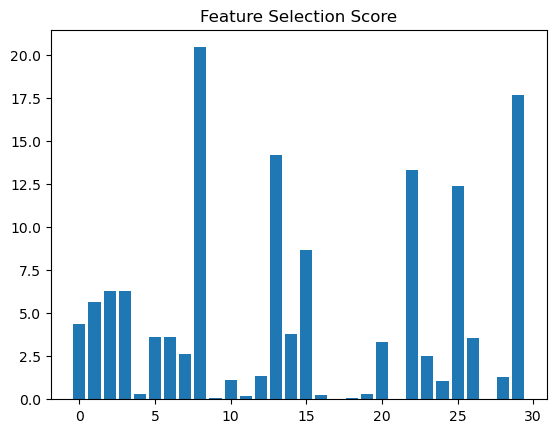

In [15]:
# feature selection
X_train_fs, fs = select_features(df_nta.drop(columns=['People_Per_Shop', 'GeoID']), df_nta['People_Per_Shop'], 15)
cols = df_nta.drop(columns=['People_Per_Shop', 'GeoID']).columns
# # what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %s: %f' % (cols[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Feature Selection Score')
plt.show()

In [16]:
selected_features = []
for idx, col in enumerate(cols):
    if fs.get_support()[idx]:
        selected_features.append(col)
selected_features

['Pop_Total_25_44',
 'Pop_Pct_25_44',
 'Pop_Male',
 'Pop_Female',
 'Pop_Pct_Hisp_Latin',
 'Pop_Pct_Non_Hisp_Latin',
 'Pop_Pct_Black',
 'Pop_Pct_Employ_Salary',
 'Pop_Pct_Household_Earn_75_99',
 'Pop_Pct_Family_Earn_75_99',
 'Pop_Pct_Healthy',
 'Median_Room',
 'Pop_Pct_With_Car',
 'Pop_Pct_with_Family',
 'Shop_Count']

# Clustering

K: 2 Score: 0.6107641540138173
K: 3 Score: 0.6144525142482168
K: 4 Score: 0.6085007801945679
K: 5 Score: 0.5702945715757467
K: 6 Score: 0.5700878356243881
K: 7 Score: 0.5687704786337021
K: 8 Score: 0.5679236983167463
K: 9 Score: 0.5642670370732447


Text(0.5, 1.0, 'Elbow Method For Optimal k')

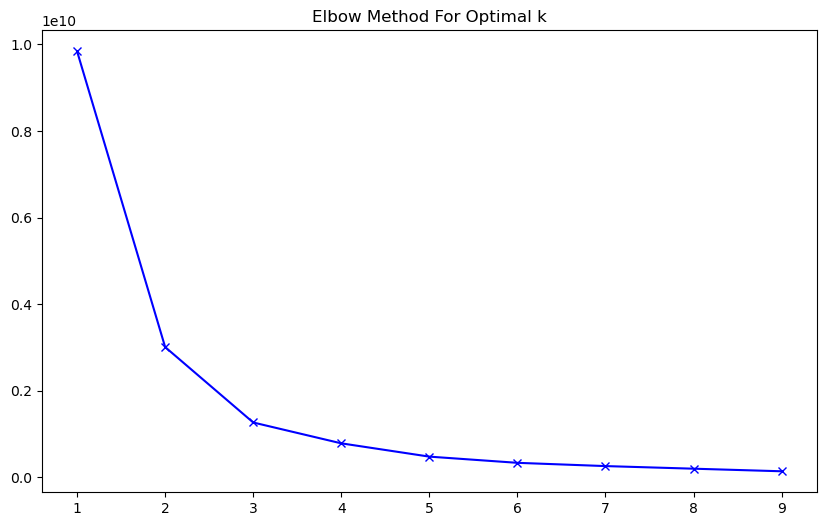

In [17]:
# Apply clustering on feature selection
sum_of_squared_distances = []

for k in range(1,10): # maximum of 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(X_train_fs)
    sum_of_squared_distances.append(kmeans.inertia_)
    if k > 1:
        print(f"K: {k} Score: {silhouette_score(X_train_fs, kmeans.fit_predict(X_train_fs))}")

plt.figure(figsize=(10, 6))
plt.plot(range(1,10), sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [18]:
k_clusters = 4

kmeans = KMeans(n_clusters=k_clusters, random_state=100).fit(X_train_fs)
print("Silhouette Coefficient:", silhouette_score(X_train_fs, kmeans.labels_))

Silhouette Coefficient: 0.5449717046516303


In [19]:
model = AgglomerativeClustering(n_clusters=k_clusters)
labels = model.fit_predict(X_train_fs)
print("Silhouette Coefficient:",  silhouette_score(X_train_fs, labels))

Silhouette Coefficient: 0.6174730946966908


In [20]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import adjusted_rand_score

print(adjusted_rand_score(kmeans.labels_, labels))
print(contingency_matrix(kmeans.labels_, labels))

0.48804721288934355
[[51  0  0  0]
 [ 0  0 20 11]
 [ 0 10  0  7]
 [18  0 24  0]]


In [21]:
nyc_cluster = df_nta.copy()
nyc_cluster['cluster_k'] = kmeans.labels_
nyc_cluster['cluster_a'] = labels
nyc_cluster

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,Pop_Pct_American,...,Median_Rent,Pop_Pct_With_Car,Pop_Pct_with_Family,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster_k,cluster_a
0,24615,0.311055,0.478037,0.521963,39.5,0.178608,0.821392,0.634329,0.019094,0.002287,...,1385.0,0.548691,0.565443,0.429271,0.464265,152,161.940789,BK31,1,3
1,25584,0.339680,0.484492,0.515508,29.1,0.194933,0.805067,0.350607,0.405826,0.000876,...,1165.0,0.312752,0.557965,0.273034,0.321807,25,1023.360000,BK75,1,3
2,18681,0.290678,0.486766,0.513234,39.6,0.123283,0.876717,0.465153,0.008262,0.000000,...,1209.0,0.540046,0.733583,0.531257,0.301847,105,177.914286,BK29,1,2
3,28128,0.306920,0.487212,0.512788,37.8,0.145975,0.854025,0.426773,0.008740,0.001211,...,1259.0,0.526765,0.729948,0.537698,0.262382,173,162.589595,BK28,2,3
4,26331,0.248610,0.510155,0.489845,25.6,0.096721,0.903279,0.757131,0.008932,0.001322,...,1341.0,0.483225,0.800452,0.680694,0.188132,99,265.969697,BK88,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,11003,0.294237,0.480439,0.519561,31.4,0.707046,0.292954,0.018986,0.231154,0.000882,...,1098.0,0.228866,0.650325,0.232837,0.139636,32,343.843750,BX63,0,0
137,10220,0.285858,0.478435,0.521565,33.0,0.646090,0.353910,0.033061,0.251091,0.000587,...,1108.0,0.394016,0.683944,0.280236,0.092649,40,255.500000,BX08,0,0
138,7933,0.278968,0.467068,0.532932,34.0,0.636249,0.363751,0.039420,0.151352,0.000000,...,1308.0,0.522319,0.696242,0.339579,0.185358,30,264.433333,BX59,0,0
139,17193,0.264333,0.461541,0.538459,34.7,0.252156,0.747844,0.023461,0.692157,0.003413,...,1204.0,0.512452,0.680864,0.278872,0.187137,42,409.357143,BX44,3,2


# Analyse clustering result

Text(0, 0.5, 'Median Household Income')

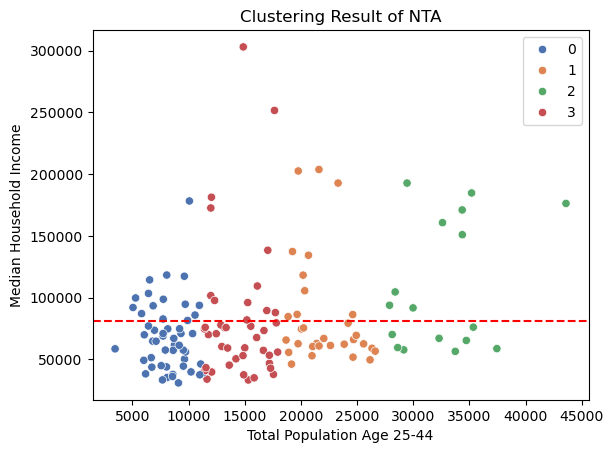

In [22]:
# visualise the clustering result
fig, ax = plt.subplots()
sns.scatterplot(data=nyc_cluster, x='Pop_Total_25_44', y='Median_Household_Income', hue='cluster_k', palette='deep')

avg_income = nyc_cluster['Median_Household_Income'].mean()
plt.axhline(y=avg_income, color='r', linestyle='--')

plt.legend()
plt.title('Clustering Result of NTA')
plt.xlabel('Total Population Age 25-44')
plt.ylabel('Median Household Income')

Text(0, 0.5, 'Median Household Income')

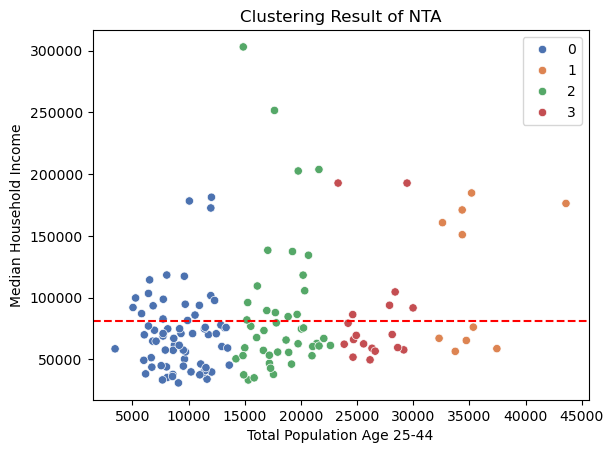

In [23]:
# visualise the clustering result
fig, ax = plt.subplots()
sns.scatterplot(data=nyc_cluster, x='Pop_Total_25_44', y='Median_Household_Income', hue='cluster_a', palette='deep')

avg_income = nyc_cluster['Median_Household_Income'].mean()
plt.axhline(y=avg_income, color='r', linestyle='--')

plt.legend()
plt.title('Clustering Result of NTA')
plt.xlabel('Total Population Age 25-44')
plt.ylabel('Median Household Income')

In [24]:
# merge the NTA metadata
nyc_cluster = pd.merge(nyc_cluster, df_pop[['GeogName', 'GeoID', 'Borough']], on = 'GeoID')
nyc_cluster.head(5)

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,Pop_Pct_American,...,Pop_Pct_with_Family,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster_k,cluster_a,GeogName,Borough
0,24615,0.311055,0.478037,0.521963,39.5,0.178608,0.821392,0.634329,0.019094,0.002287,...,0.565443,0.429271,0.464265,152,161.940789,BK31,1,3,Bay Ridge,Brooklyn
1,25584,0.339680,0.484492,0.515508,29.1,0.194933,0.805067,0.350607,0.405826,0.000876,...,0.557965,0.273034,0.321807,25,1023.360000,BK75,1,3,Bedford,Brooklyn
2,18681,0.290678,0.486766,0.513234,39.6,0.123283,0.876717,0.465153,0.008262,0.000000,...,0.733583,0.531257,0.301847,105,177.914286,BK29,1,2,Bensonhurst East,Brooklyn
3,28128,0.306920,0.487212,0.512788,37.8,0.145975,0.854025,0.426773,0.008740,0.001211,...,0.729948,0.537698,0.262382,173,162.589595,BK28,2,3,Bensonhurst West,Brooklyn
4,26331,0.248610,0.510155,0.489845,25.6,0.096721,0.903279,0.757131,0.008932,0.001322,...,0.800452,0.680694,0.188132,99,265.969697,BK88,1,3,Borough Park,Brooklyn


In [25]:
nyc_cluster['cluster'] = labels

# create new dataframe to summarise each label
filtered_columns.pop()

results = []
for cluster in sorted(nyc_cluster.cluster.unique()):
    df = nyc_cluster[nyc_cluster.cluster == cluster]
    nta_names = df.GeogName.unique()
    nta_ids = df.GeoID.unique()
    cluster_dict = {
        'cluster': cluster,
        'NTA_Name': df.GeogName.unique(),
        'NTA_ID': df.GeoID.unique(),
        'Num_NTA': df.GeoID.nunique()
    }
    for col in filtered_columns:
        cluster_dict[f'Avg_{col}'] = df[col].mean()
    results.append(cluster_dict)
    print(f"Group {cluster}")

Group 0
Group 1
Group 2
Group 3


In [26]:
df_results = pd.DataFrame(results)
df_results.head()

,cluster,NTA_Name,NTA_ID,Num_NTA,Avg_Pop_Total_25_44,Avg_Pop_Pct_25_44,Avg_Pop_Male,Avg_Pop_Female,Avg_Median_Age,Avg_Pop_Pct_Hisp_Latin,...,Avg_Pct_Occupied_House,Avg_Median_Room,Avg_Median_House,Avg_Median_Rent,Avg_Pop_Pct_With_Car,Avg_Pop_Pct_with_Family,Avg_Pop_Pct_with_Couple,Avg_Pop_Pct_With_Degree,Avg_Shop_Count,Avg_People_Per_Shop
0,0,"[Brighton Beach, Brooklyn Heights-Cobble Hill,...","[BK19, BK09, BK63, BK85, BK95, BK68, BK45, BK2...",69,9273.289855,0.293578,0.472642,0.527358,36.169565,0.325935,...,0.920478,4.126087,478778.710145,1282.275362,0.510968,0.640488,0.365076,0.306878,23.289855,1067.780553
1,1,"[Crown Heights North, Flatbush, Park Slope-Gow...","[BK61, BK42, BK37, MN13, MN31, MN12, MN36, MN3...",10,35368.400000,0.386583,0.472436,0.527564,36.830000,0.254038,...,0.903262,3.570000,719265.500000,1646.700000,0.320209,0.487197,0.317877,0.548167,101.500000,438.258635
2,2,"[Bensonhurst East, Brownsville, Carroll Garden...","[BK29, BK81, BK33, BK69, BK38, BK90, BK58, BK7...",44,18133.636364,0.337302,0.477059,0.522941,35.640909,0.327453,...,0.909664,3.861364,619563.454545,1385.818182,0.359477,0.576810,0.318577,0.371229,56.954545,533.155100
3,3,"[Bay Ridge, Bedford, Bensonhurst West, Borough...","[BK31, BK75, BK28, BK88, BK77, BK78, BK82, BK7...",18,26474.722222,0.358843,0.490293,0.509707,34.233333,0.302941,...,0.910597,3.911111,621539.666667,1469.944444,0.391193,0.594434,0.377446,0.368748,90.500000,529.344425


In [27]:
# for each attribute give me the label that has the highest average
best_cluster_per_feature = {}
for col in df_results.columns[3:]:
    if col != 'Avg_shop_count':
        max_index = df_results[col].idxmax()
        cluster = df_results.loc[max_index]['cluster']
    else:
        min_index = df_results[col].idxmin()
        cluster = df_results.loc[min_index]['cluster']
    print(f"Variable: {col} Cluster: {cluster}")
    best_cluster_per_feature[col] = cluster

Variable: Num_NTA Cluster: 0
Variable: Avg_Pop_Total_25_44 Cluster: 1
Variable: Avg_Pop_Pct_25_44 Cluster: 1
Variable: Avg_Pop_Male Cluster: 3
Variable: Avg_Pop_Female Cluster: 1
Variable: Avg_Median_Age Cluster: 1
Variable: Avg_Pop_Pct_Hisp_Latin Cluster: 2
Variable: Avg_Pop_Pct_Non_Hisp_Latin Cluster: 1
Variable: Avg_Pop_Pct_White Cluster: 1
Variable: Avg_Pop_Pct_Black Cluster: 2
Variable: Avg_Pop_Pct_American Cluster: 2
Variable: Avg_Pop_Pct_Asia Cluster: 3
Variable: Avg_Pop_Pct_Native Cluster: 1
Variable: Avg_Pop_Pct_Employ Cluster: 1
Variable: Avg_Pop_Pct_Employ_Salary Cluster: 3
Variable: Avg_Pop_Pct_Household_Earn_75_99 Cluster: 0
Variable: Avg_Pop_Pct_Family_Earn_75_99 Cluster: 0
Variable: Avg_Median_Household_Income Cluster: 1
Variable: Avg_Median_Family_Income Cluster: 1
Variable: Avg_Median_Earning Cluster: 1
Variable: Avg_People_Per_Parking Cluster: 2
Variable: Avg_Pop_Pct_Healthy Cluster: 1
Variable: Avg_Pct_Occupied_House Cluster: 0
Variable: Avg_Median_Room Cluster: 0
Va

In [28]:
best_cluster = Counter(best_cluster_per_feature.values())
best_cluster = max(best_cluster, key=best_cluster.get)
best_cluster

1

In [29]:
nyc_cluster_result = nyc_cluster[nyc_cluster.cluster == best_cluster]
nyc_cluster_result = nyc_cluster_result.reset_index()
nyc_cluster_result.head(5)

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,...,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster_k,cluster_a,GeogName,Borough,cluster
0,12,37446,0.349525,0.449913,0.550087,33.7,0.123089,0.876911,0.157308,0.659156,...,0.191180,0.316074,56,668.678571,BK61,2,1,Crown Heights North,Brooklyn,1
1,19,34725,0.319595,0.462794,0.537206,34.3,0.189493,0.810507,0.224191,0.451594,...,0.350695,0.334753,154,225.487013,BK42,2,1,Flatbush,Brooklyn,1
2,29,32605,0.441318,0.481152,0.518848,35.4,0.166701,0.833299,0.669130,0.044125,...,0.440588,0.756533,73,446.643836,BK37,2,1,Park Slope-Gowanus,Brooklyn,1
3,51,35194,0.455851,0.520174,0.479826,37.1,0.140380,0.859620,0.631449,0.057367,...,0.237276,0.744207,107,328.915888,MN13,2,1,Hudson Yards-Chelsea-Flat Iron-Union Square,Manhattan,1
4,52,34358,0.418740,0.443724,0.556276,37.7,0.090334,0.909666,0.719906,0.038964,...,0.319097,0.783111,56,613.535714,MN31,2,1,Lenox Hill-Roosevelt Island,Manhattan,1


<Axes: title={'center': 'NYC residential neighbourhoods'}, xlabel='People per shop', ylabel='Mean Household Income'>

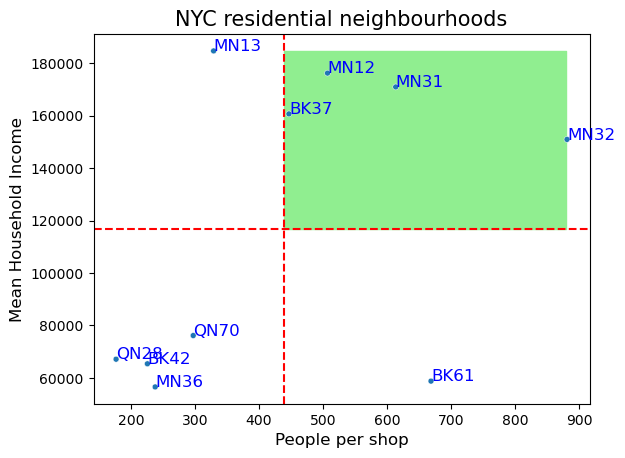

In [38]:
# https://towardsdatascience.com/store-locations-d1025df22865
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    p1 = sns.scatterplot(x=x, y=y, data=data, size=8, legend=False)

    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='blue') for line in range(0,data.shape[0])]

    plt.title(title, size=15)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    
    return p1
    
# Using the average people per shop and average income as the threshold
avg_people_per_shop = nyc_cluster_result['People_Per_Shop'].mean()
max_people_per_shop = nyc_cluster_result['People_Per_Shop'].max()
avg_income = nyc_cluster_result['Median_Household_Income'].mean()
max_income = nyc_cluster_result['Median_Household_Income'].max()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_shop, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_shop, max_people_per_shop), y1=avg_income, y2=max_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People_Per_Shop', 'Median_Household_Income', 'GeoID',
             data = nyc_cluster_result, 
             title = 'NYC residential neighbourhoods', 
             xlabel = 'People per shop',
             ylabel = 'Household Income')

In [39]:
top_result = nyc_cluster_result.loc[nyc_cluster_result.People_Per_Shop.idxmax()]
top_result

index                                   67
Pop_Total_25_44                      34367
Pop_Pct_25_44                     0.422833
Pop_Male                          0.430227
Pop_Female                        0.569773
Median_Age                            38.1
Pop_Pct_Hisp_Latin                0.103386
Pop_Pct_Non_Hisp_Latin            0.896614
Pop_Pct_White                     0.745934
Pop_Pct_Black                     0.030685
Pop_Pct_American                  0.000431
Pop_Pct_Asia                      0.089237
Pop_Pct_Native                    0.001649
Pop_Pct_Employ                    0.718739
Pop_Pct_Employ_Salary             0.858965
Pop_Pct_Household_Earn_75_99      0.117675
Pop_Pct_Family_Earn_75_99         0.083422
Median_Household_Income           150969.0
Median_Family_Income              165223.0
Median_Earning                     72077.0
People_Per_Parking               60.784577
Pop_Pct_Healthy                   0.949504
Pct_Occupied_House                0.913228
Median_Room

In [40]:
# Top 10 recommendations sorted by opportunity value
nyc_cluster_result.sort_values('People_Per_Shop', ascending=False)[['GeoID', 'GeogName', 'Borough', 'Median_Household_Income', 'People_Per_Shop']].head()

,GeoID,GeogName,Borough,Median_Household_Income,People_Per_Shop
7,MN32,Yorkville,Manhattan,150969.0,881.205128
0,BK61,Crown Heights North,Brooklyn,58756.0,668.678571
4,MN31,Lenox Hill-Roosevelt Island,Manhattan,170988.0,613.535714
5,MN12,Upper West Side,Manhattan,176267.0,506.941860
2,BK37,Park Slope-Gowanus,Brooklyn,160700.0,446.643836


# Plot the Recommendation on Map

In [33]:
# filter the list of shops in the recommended area
df_bus_shop = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
df_bus_shop = df_bus_shop[['Address Borough', 'NTA', 'Business Name', 'Industry', 'Location']]
df_bus_shop = df_bus_shop[df_bus_shop['NTA'] == top_result.GeoID]

print("Numer of potential competitors: ", df_bus_shop.shape[0])
df_bus_shop.head(5)

Numer of potential competitors:  39


,Address Borough,NTA,Business Name,Industry,Location
27498,Manhattan,MN32,"C & G TWINS, CORP",Stoop Line Stand,"(40.77617572812778, -73.94695339149135)"
28951,Manhattan,MN32,Y C DELI GOURMET MARKET INC,Stoop Line Stand,"(40.775091744448666, -73.9537600839611)"
58320,Manhattan,MN32,OM SAI UPPER EASTSIDE GROCERY INC,Stoop Line Stand,"(40.775091744448666, -73.9537600839611)"
59998,Manhattan,MN32,1576 FIRST AVE. MARKET CORP.,Stoop Line Stand,"(40.77419046685926, -73.95132364223564)"
60425,Manhattan,MN32,HYBRID FLORIST LTD.,Stoop Line Stand,"(40.777305336555955, -73.95036815650805)"


In [34]:
# # Central Harlem North-Polo Grounds
# top_location = (40.81655608001756, -73.94476397671313)

# # https://locations.traderjoes.com/ny/new-york/
# trade_joes_locs = [
#     (40.77868573574113, -73.98165974388836),
#     (40.7422363888565, -73.9938099666359),
#     (40.74220387389157, -73.99384215314335),
#     (40.71662851329304, -73.98622463224902),
#     (40.808942800620464, -73.9447919734825),
#     (40.74404302923888, -73.97841446875535),
#     (40.72588669406502, -74.00444429177101),
#     (40.73346852919018, -73.9875103647856),
#     (40.759841323514586, -73.9612664819784),
#     (40.79093941325663, -73.96869388621614)
# ]

# mapit = folium.Map(top_location, zoom_start=12) #initial location 
# folium.Marker(location=top_location, 
#               tooltip="New Trader Joe's",
#               icon=folium.Icon(color='green')).add_to(mapit)
# for coord in df_bus_shop['Location']:
#     coord = ast.literal_eval(coord)
#     folium.Marker(location=[coord[0], coord[1]],
#                   tooltip='Competitor',
#                   icon=folium.Icon(color='red')).add_to(mapit)
# for coord in trade_joes_locs:
#     folium.Marker(location=[coord[0], coord[1]],
#                   tooltip="Trader Joe's",
#                   icon=folium.Icon(color='blue')).add_to(mapit)
# mapit.save("recommended_location.html")

# Visualise the second-best

<Axes: title={'center': 'NYC residential neighbourhoods'}, xlabel='People per shop', ylabel='Household Income'>

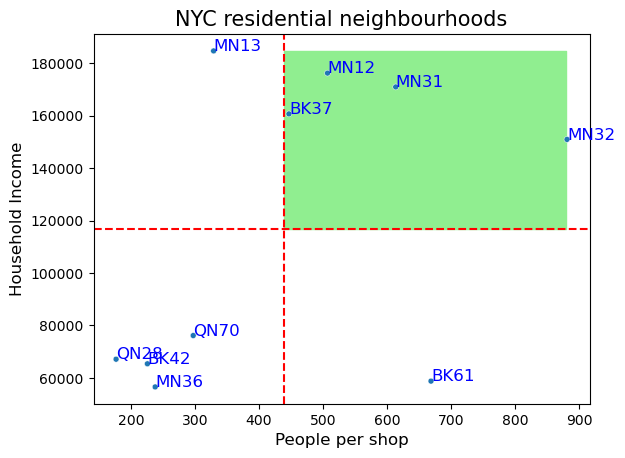

In [41]:
plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_shop, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_shop, max_people_per_shop), y1=avg_income, y2=max_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People_Per_Shop', 'Median_Household_Income', 'GeoID',
             data = nyc_cluster_result, 
             title = 'NYC residential neighbourhoods', 
             xlabel = 'People per shop',
             ylabel = 'Household Income')

In [36]:
# # Yorkville
# top_location = (40.77625377765895, -73.94895369875373)

# # filter the list of shops in the recommended area
# df_bus_shop = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
# df_bus_shop = df_bus_shop[['Address Borough', 'NTA', 'Business Name', 'Industry', 'Location']]
# df_bus_shop = df_bus_shop[df_bus_shop['NTA'] == 'MN32']

# print("Numer of potential competitors: ", df_bus_shop.shape[0])

# mapit = folium.Map(top_location, zoom_start=12) #initial location 
# folium.Marker(location=top_location, 
#               tooltip="New Trader Joe's",
#               icon=folium.Icon(color='green')).add_to(mapit)
# for coord in df_bus_shop['Location']:
#     coord = ast.literal_eval(coord)
#     folium.Marker(location=[coord[0], coord[1]],
#                   tooltip='Competitor',
#                   icon=folium.Icon(color='red')).add_to(mapit)
# for coord in trade_joes_locs:
#     folium.Marker(location=[coord[0], coord[1]],
#                   tooltip="Trader Joe's",
#                   icon=folium.Icon(color='blue')).add_to(mapit)
# mapit.save("recommended_location_second_best.html")

In [37]:
nyc_cluster_result.loc[11]

KeyError: 11